1
2
4
8
16
32


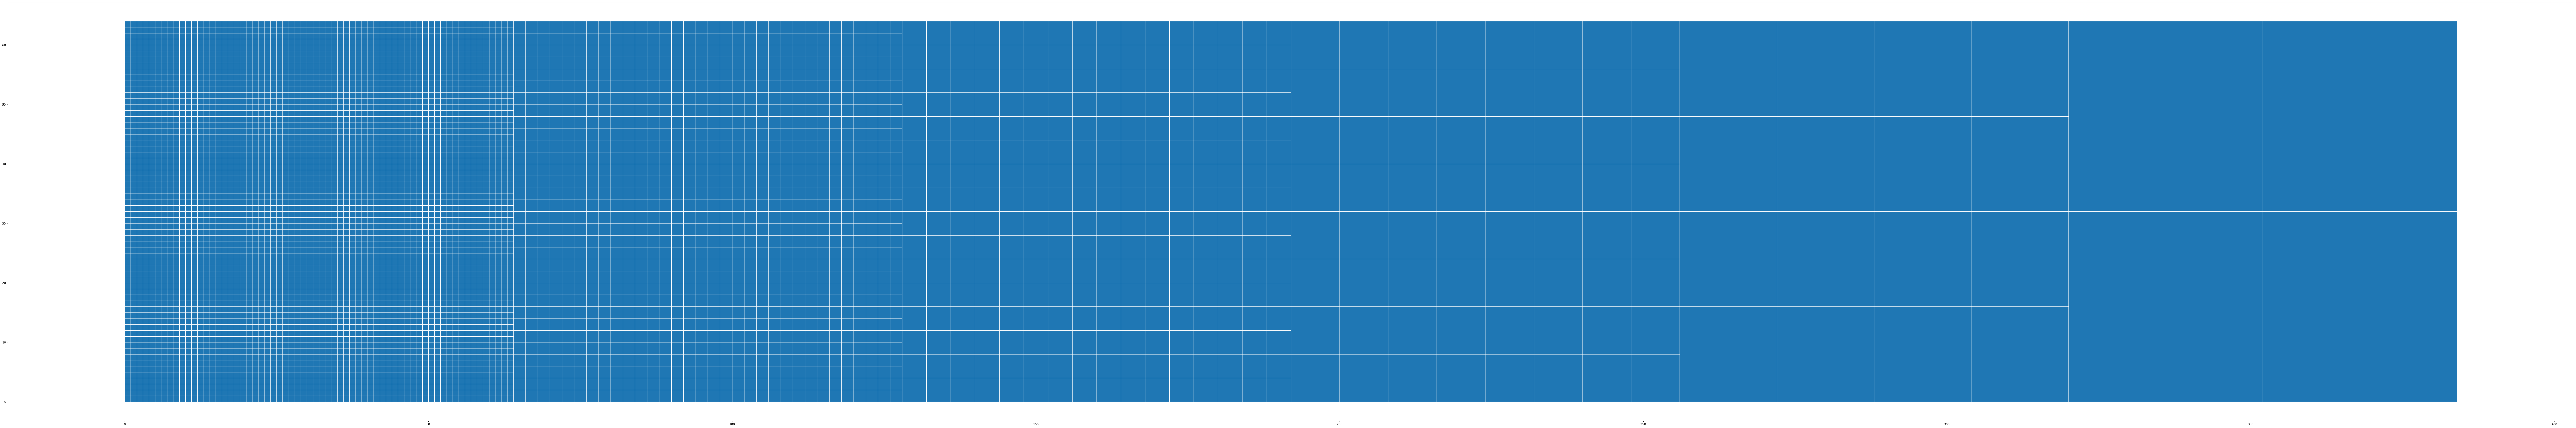

In [1]:
import geopandas as gpd
from shapely.geometry import Polygon
import os
import matplotlib.pyplot as plt

top_pow = 6
n_rows = 2**top_pow
n_cols = n_rows


try:
    os.mkdir(f"linear_multigrid")
except:
    pass


polygons = list()
poly_data = list()

def create_polygon(x, y, size):
    return Polygon([(x, y), (x + size, y), (x + size, y + size), (x, y + size)]), {"TOTPOP": size*size, "Label": f"{size}x{size}", "lowerx": x, "lowery": y, "upperx": x + size, "uppery": y + size}

for mod in range(0,top_pow):
    print(2**mod)
    for i in range(0, n_rows, 2**mod):
        for j in range(0, n_cols, 2**mod):
            poly, data = create_polygon(i + n_cols*mod, j, 2**mod)
            polygons.append(poly)
            poly_data.append(data)

linear_gdf = gpd.GeoDataFrame(poly_data, geometry=polygons)

fig, ax = plt.subplots(figsize=(120, 20))
linear_gdf.plot(ax=ax, edgecolor="white")
ax.set_aspect("auto")  # or ax.set_aspect("equal", "box")
plt.tight_layout()
plt.show()


In [2]:
centriods = linear_gdf.centroid
linear_gdf['x'] = centriods.x
linear_gdf['y'] = centriods.y

linear_gdf

,TOTPOP,Label,lowerx,lowery,upperx,uppery,geometry,x,y
0,1,1x1,0,0,1,1,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))",0.5,0.5
1,1,1x1,0,1,1,2,"POLYGON ((0 1, 1 1, 1 2, 0 2, 0 1))",0.5,1.5
2,1,1x1,0,2,1,3,"POLYGON ((0 2, 1 2, 1 3, 0 3, 0 2))",0.5,2.5
3,1,1x1,0,3,1,4,"POLYGON ((0 3, 1 3, 1 4, 0 4, 0 3))",0.5,3.5
4,1,1x1,0,4,1,5,"POLYGON ((0 4, 1 4, 1 5, 0 5, 0 4))",0.5,4.5
...,...,...,...,...,...,...,...,...,...
5455,256,16x16,304,48,320,64,"POLYGON ((304 48, 320 48, 320 64, 304 64, 304 ...",312.0,56.0
5456,1024,32x32,320,0,352,32,"POLYGON ((320 0, 352 0, 352 32, 320 32, 320 0))",336.0,16.0
5457,1024,32x32,320,32,352,64,"POLYGON ((320 32, 352 32, 352 64, 320 64, 320 ...",336.0,48.0
5458,1024,32x32,352,0,384,32,"POLYGON ((352 0, 384 0, 384 32, 352 32, 352 0))",368.0,16.0


In [3]:
boundary_node = [False] * len(linear_gdf)
boundary_perim = [0] * len(linear_gdf)
for i, row in linear_gdf.iterrows():
    boundary_node[i] = (
        row["lowerx"] == 0
        or row["upperx"] == 384
        or row["lowery"] == 0
        or row["uppery"] == 64
    )
    if boundary_node[i]:
        boundary_perim[i] = (
            int(row["lowerx"] == 0) * int(row["Label"].split('x')[0]) + 
            int(row["upperx"] == 384) * int(row["Label"].split('x')[0]) + 
            int(row["lowery"] == 0) * int(row["Label"].split('x')[0]) + 
            int(row["uppery"] == 64) * int(row["Label"].split('x')[0]) 
        )
linear_gdf["bdry_node"] = boundary_node
linear_gdf["bdry_perim"] = boundary_perim

In [4]:
assignment_dict = {
    "1x1": 1,
    "2x2": 2,
    "4x4": 3,
    "8x8": 4,
    "16x16": 5,
    "32x32": 6,
}


linear_gdf["assignment"] = [assignment_dict[x] for x in linear_gdf["Label"]]
linear_gdf

,TOTPOP,Label,lowerx,lowery,upperx,uppery,geometry,x,y,bdry_node,bdry_perim,assignment
0,1,1x1,0,0,1,1,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))",0.5,0.5,True,2,1
1,1,1x1,0,1,1,2,"POLYGON ((0 1, 1 1, 1 2, 0 2, 0 1))",0.5,1.5,True,1,1
2,1,1x1,0,2,1,3,"POLYGON ((0 2, 1 2, 1 3, 0 3, 0 2))",0.5,2.5,True,1,1
3,1,1x1,0,3,1,4,"POLYGON ((0 3, 1 3, 1 4, 0 4, 0 3))",0.5,3.5,True,1,1
4,1,1x1,0,4,1,5,"POLYGON ((0 4, 1 4, 1 5, 0 5, 0 4))",0.5,4.5,True,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5455,256,16x16,304,48,320,64,"POLYGON ((304 48, 320 48, 320 64, 304 64, 304 ...",312.0,56.0,True,16,5
5456,1024,32x32,320,0,352,32,"POLYGON ((320 0, 352 0, 352 32, 320 32, 320 0))",336.0,16.0,True,32,6
5457,1024,32x32,320,32,352,64,"POLYGON ((320 32, 352 32, 352 64, 320 64, 320 ...",336.0,48.0,True,32,6
5458,1024,32x32,352,0,384,32,"POLYGON ((352 0, 384 0, 384 32, 352 32, 352 0))",368.0,16.0,True,64,6


In [5]:
linear_gdf["precinct"] = [f"Pct_{i}" for i in range(len(linear_gdf))]
linear_gdf = linear_gdf[["TOTPOP", "x", "y", "bdry_node", "bdry_perim", "assignment", "precinct", "geometry"]]
linear_gdf

,TOTPOP,x,y,bdry_node,bdry_perim,assignment,precinct,geometry
0,1,0.5,0.5,True,2,1,Pct_0,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))"
1,1,0.5,1.5,True,1,1,Pct_1,"POLYGON ((0 1, 1 1, 1 2, 0 2, 0 1))"
2,1,0.5,2.5,True,1,1,Pct_2,"POLYGON ((0 2, 1 2, 1 3, 0 3, 0 2))"
3,1,0.5,3.5,True,1,1,Pct_3,"POLYGON ((0 3, 1 3, 1 4, 0 4, 0 3))"
4,1,0.5,4.5,True,1,1,Pct_4,"POLYGON ((0 4, 1 4, 1 5, 0 5, 0 4))"
...,...,...,...,...,...,...,...,...
5455,256,312.0,56.0,True,16,5,Pct_5455,"POLYGON ((304 48, 320 48, 320 64, 304 64, 304 ..."
5456,1024,336.0,16.0,True,32,6,Pct_5456,"POLYGON ((320 0, 352 0, 352 32, 320 32, 320 0))"
5457,1024,336.0,48.0,True,32,6,Pct_5457,"POLYGON ((320 32, 352 32, 352 64, 320 64, 320 ..."
5458,1024,368.0,16.0,True,64,6,Pct_5458,"POLYGON ((352 0, 384 0, 384 32, 352 32, 352 0))"


In [6]:
linear_gdf.to_file(f"linear_multigrid/linear_multigrid.shp") 

/Users/peterrock/Library/CloudStorage/Dropbox/MADLAB/Git_Repos/peter/Multigrid_comparison/.venv/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


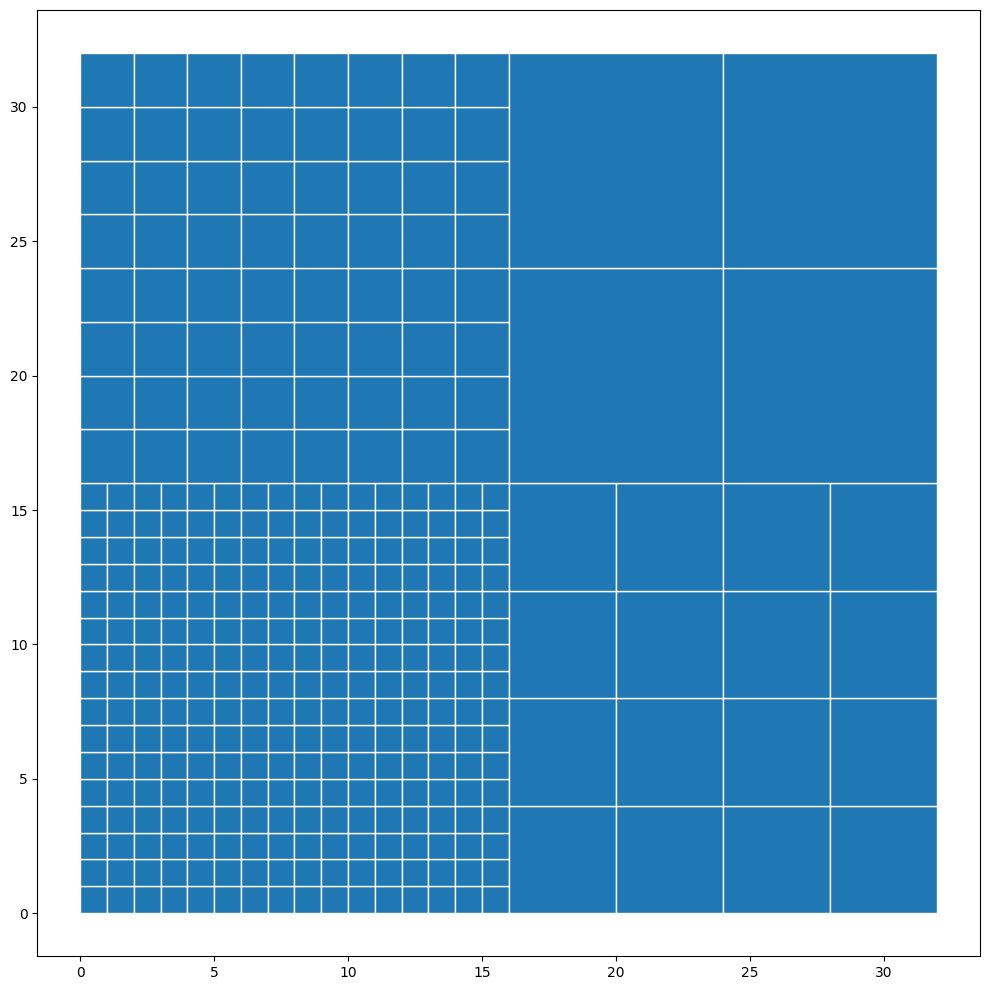

In [7]:

import geopandas as gpd
from shapely.geometry import Polygon
import os
import math


try:
    os.mkdir(f"square_multigrid")
except:
    pass


polygons = list()
poly_data = list()

def create_polygon(x, y, size):
    return Polygon([(x, y), (x + size, y), (x + size, y + size), (x, y + size)]), {"TOTPOP": size*size, "Label": f"{size}x{size}", "lowerx": x, "lowery": y, "upperx": x + size, "uppery": y + size}



def make_grid(n_rows, n_cols, x_offset, y_offset, size, polygons, poly_data):
    for i in range(0, n_rows, size):
        for j in range(0, n_cols, size):
            poly, data = create_polygon(i + x_offset, j + y_offset, size)
            polygons.append(poly)
            poly_data.append(data)

# make 16x16 grid
n_rows = 16
n_cols = 16
size = 1

make_grid(n_rows, n_cols, 0, 0, 1, polygons, poly_data)
make_grid(n_rows, n_cols, 0, n_rows, 2, polygons, poly_data)
make_grid(n_rows, n_cols, n_cols, 0, 4, polygons, poly_data)
make_grid(n_rows, n_cols, n_cols, n_rows, 8, polygons, poly_data)


square_gdf = gpd.GeoDataFrame(poly_data, geometry=polygons)

fig, ax = plt.subplots(figsize=(10,10))
square_gdf.plot(ax=ax, edgecolor="white")
ax.set_aspect("auto")  # or ax.set_aspect("equal", "box")
plt.tight_layout()
plt.show()


In [8]:
boundary_node = [False] * len(square_gdf)
boundary_perim = [0] * len(square_gdf)
for i, row in square_gdf.iterrows():
    boundary_node[i] = (
        row["lowerx"] == 0
        or row["upperx"] == 32
        or row["lowery"] == 0
        or row["uppery"] == 32
    )
    if boundary_node[i]:
        boundary_perim[i] = (
            int(row["lowerx"] == 0) * int(row["Label"].split('x')[0]) + 
            int(row["upperx"] == 32) * int(row["Label"].split('x')[0]) + 
            int(row["lowery"] == 0) * int(row["Label"].split('x')[0]) + 
            int(row["uppery"] == 32) * int(row["Label"].split('x')[0]) 
        )
square_gdf["bdry_node"] = boundary_node
square_gdf["bdry_perim"] = boundary_perim

In [9]:
centriods = square_gdf.centroid
square_gdf["x"] = centriods.x
square_gdf["y"] = centriods.y

In [10]:
square_gdf["assignment"] = [assignment_dict[x] for x in square_gdf["Label"]]

square_gdf

,TOTPOP,Label,lowerx,lowery,upperx,uppery,geometry,bdry_node,bdry_perim,x,y,assignment
0,1,1x1,0,0,1,1,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))",True,2,0.5,0.5,1
1,1,1x1,0,1,1,2,"POLYGON ((0 1, 1 1, 1 2, 0 2, 0 1))",True,1,0.5,1.5,1
2,1,1x1,0,2,1,3,"POLYGON ((0 2, 1 2, 1 3, 0 3, 0 2))",True,1,0.5,2.5,1
3,1,1x1,0,3,1,4,"POLYGON ((0 3, 1 3, 1 4, 0 4, 0 3))",True,1,0.5,3.5,1
4,1,1x1,0,4,1,5,"POLYGON ((0 4, 1 4, 1 5, 0 5, 0 4))",True,1,0.5,4.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
335,16,4x4,28,12,32,16,"POLYGON ((28 12, 32 12, 32 16, 28 16, 28 12))",True,4,30.0,14.0,3
336,64,8x8,16,16,24,24,"POLYGON ((16 16, 24 16, 24 24, 16 24, 16 16))",False,0,20.0,20.0,4
337,64,8x8,16,24,24,32,"POLYGON ((16 24, 24 24, 24 32, 16 32, 16 24))",True,8,20.0,28.0,4
338,64,8x8,24,16,32,24,"POLYGON ((24 16, 32 16, 32 24, 24 24, 24 16))",True,8,28.0,20.0,4


In [11]:
square_gdf["precinct"] = [f"Pct_{i}" for i in range(len(square_gdf))]
square_gdf = square_gdf[["TOTPOP", "x", "y", "bdry_node", "bdry_perim", "assignment", "precinct", "geometry"]]


In [12]:
square_gdf.to_file(f"square_multigrid/square_multigrid.shp")  

/Users/peterrock/Library/CloudStorage/Dropbox/MADLAB/Git_Repos/peter/Multigrid_comparison/.venv/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [13]:
from gerrychain import Graph

In [14]:
linear_multigraph = Graph.from_geodataframe(linear_gdf)

/Users/peterrock/Library/CloudStorage/Dropbox/MADLAB/Git_Repos/peter/Multigrid_comparison/.venv/lib/python3.11/site-packages/gerrychain/graph/graph.py:275: UserWarning: GeoDataFrame has no CRS. Did you forget to set it? If you're sure this is correct, you can ignore this warning. Otherwise, please set the CRS using the `crs_override` parameter. Attempting to proceed without a CRS.
  warnings.warn(


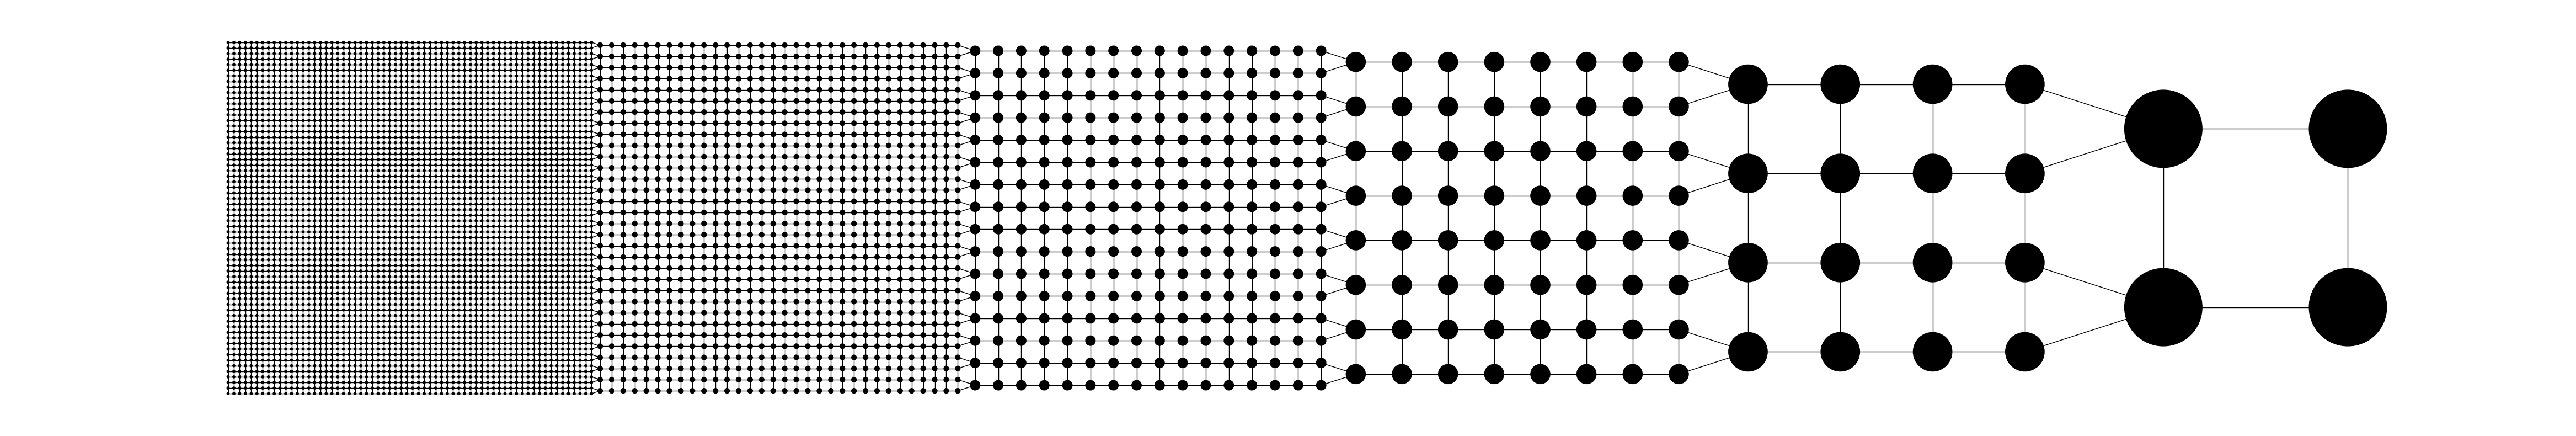

In [15]:
import networkx as nx

pos = {n: (d['x'], d['y']) for n,d in linear_multigraph.nodes(data=True)}
sizes = [10*d["TOTPOP"] for _,d in linear_multigraph.nodes(data=True)]

fig, ax = plt.subplots(figsize=(60,10)) 
nx.draw(linear_multigraph, pos, ax=ax, node_color='black', node_size=sizes, with_labels=False)
plt.savefig("./figures/linear_multigrid.png",bbox_inches='tight')

In [16]:
square_multigraph = Graph.from_geodataframe(square_gdf)

/Users/peterrock/Library/CloudStorage/Dropbox/MADLAB/Git_Repos/peter/Multigrid_comparison/.venv/lib/python3.11/site-packages/gerrychain/graph/graph.py:275: UserWarning: GeoDataFrame has no CRS. Did you forget to set it? If you're sure this is correct, you can ignore this warning. Otherwise, please set the CRS using the `crs_override` parameter. Attempting to proceed without a CRS.
  warnings.warn(


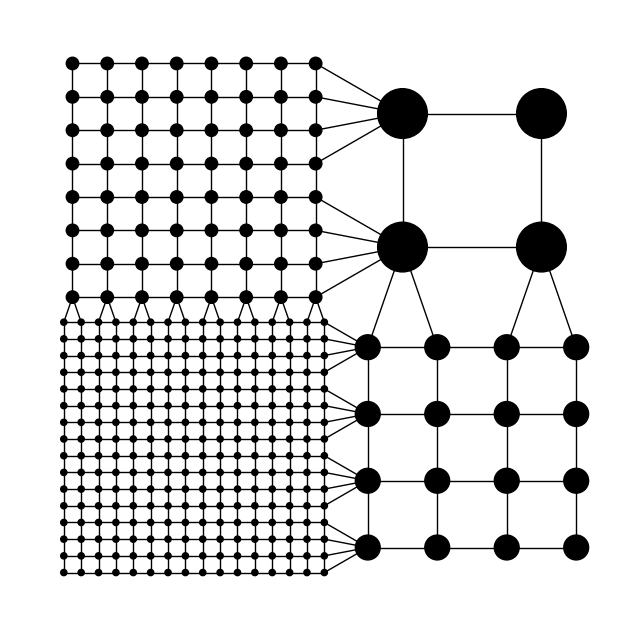

In [17]:
pos = {n: (d['x'], d['y']) for n,d in square_multigraph.nodes(data=True)}
sizes = [20*d["TOTPOP"] for _,d in square_multigraph.nodes(data=True)]

fig, ax = plt.subplots(figsize=(8,8)) 
nx.draw(square_multigraph, pos, ax=ax, node_color='black', node_size=sizes, with_labels=False)
plt.savefig("./figures/square_multigrid.png", bbox_inches='tight')

In [18]:
from gerrychain import Partition
from gerrychain.updaters import Tally
square_partition = Partition(
    graph = square_multigraph,
    assignment = "assignment",
    updaters={
        "population": Tally(fields="TOTPOP", alias="population"),
    }
)

print(square_partition.population)

linear_partition = Partition(
    graph = linear_multigraph,
    assignment = "assignment",
    updaters={
        "population": Tally(fields="TOTPOP", alias="population"),
    }
)

print(linear_partition.population)

{1: 256, 2: 256, 3: 256, 4: 256}
{1: 4096, 2: 4096, 3: 4096, 4: 4096, 5: 4096, 6: 4096}


In [19]:
square_multigraph.to_json('./JSON/square_multigraph.json')
linear_multigraph.to_json('./JSON/linear_multigraph.json')